In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from PIL import Image, ImageOps

# define model and load weights
output_dir= repo_path / 'results/fusion_healthy'
pipe = StableDiffusionPipeline.from_pretrained(output_dir, safety_checker=None, torch_dtype=torch.float16).to("cuda")
generator = torch.Generator(device='cuda')
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

/home/ricardo/miniconda3/envs/dreambooth/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [2]:
def show_row(imgs, figsize=(10, 10), title="", **kwargs):
    """Show generated images in a row

    Args:
        imgs (list): images list (PILs or numpy arrays)
        figsize (tuple, optional): figure size. Defaults to (10, 10).
        title (str, optional): title. Defaults to "".
    """
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize)
    fig.suptitle(title)
    for i, img in enumerate(imgs):
        axs[i].imshow(img, **kwargs)
        axs[i].axis("off")
    fig.tight_layout()

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

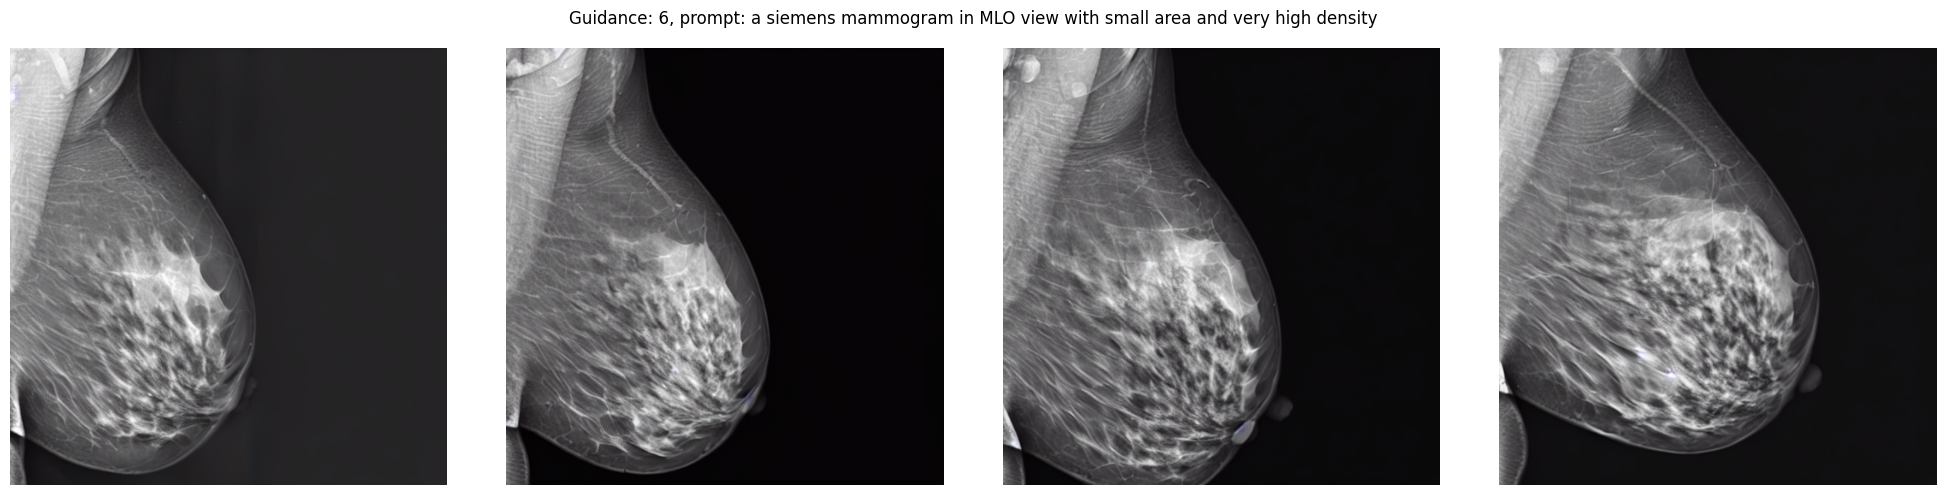

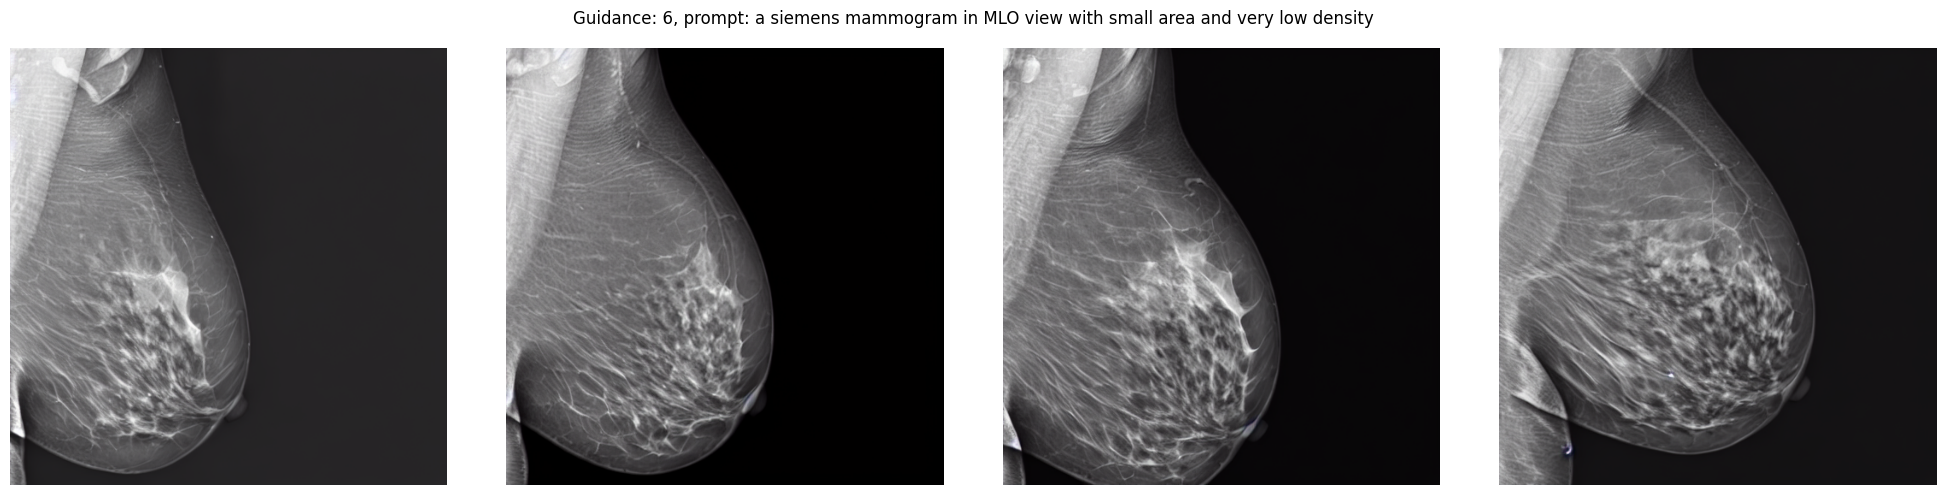

In [3]:
# Saving images
# saving_images = False
# saving_name = output_dir.replace('Likalto4/', '')
# saving_folder = repo_path / 'experiments/inference/data/synthetic' / saving_name
# saving_folder.mkdir(parents=False, exist_ok=True)

# Param
for guidance_scale in range(6,7):    
    for prompt in ['a siemens mammogram in MLO view with small area and very high density',
                'a siemens mammogram in MLO view with small area and very low density',
    ]:
        # Seed
        for seed in [1338]:
            generator.manual_seed(seed)
            negative_prompt = ""
            num_samples = 4
            num_inference_steps = 24
            size = 512
            with torch.autocast("cuda"), torch.inference_mode():
                image = pipe(
                    prompt=prompt,
                    negative_prompt=negative_prompt,
                    num_images_per_prompt=num_samples,
                    num_inference_steps=num_inference_steps,
                    guidance_scale=guidance_scale,
                    height=size,
                    width=size,
                    generator=generator,
                ).images
            # images in list
            imgs = [np.asarray(img) for img in image]

            show_row(imgs, title=f'Guidance: {guidance_scale}, prompt: {prompt}', figsize=(20,5), cmap="gray") if len(imgs) > 1 else plt.imshow(imgs[0], cmap="gray")

            # # save images
            # if saving_images:
            #     prompt_save = prompt.replace(', ', '_').replace(' ', '_')
            #     for i, img in enumerate(imgs):
            #         cv.imwrite(str(saving_folder / f'{prompt_save}_{guidance_scale}_{i}.png'), img)
            
            # # free memory
            # del image
            # del imgs
            torch.cuda.empty_cache()
            

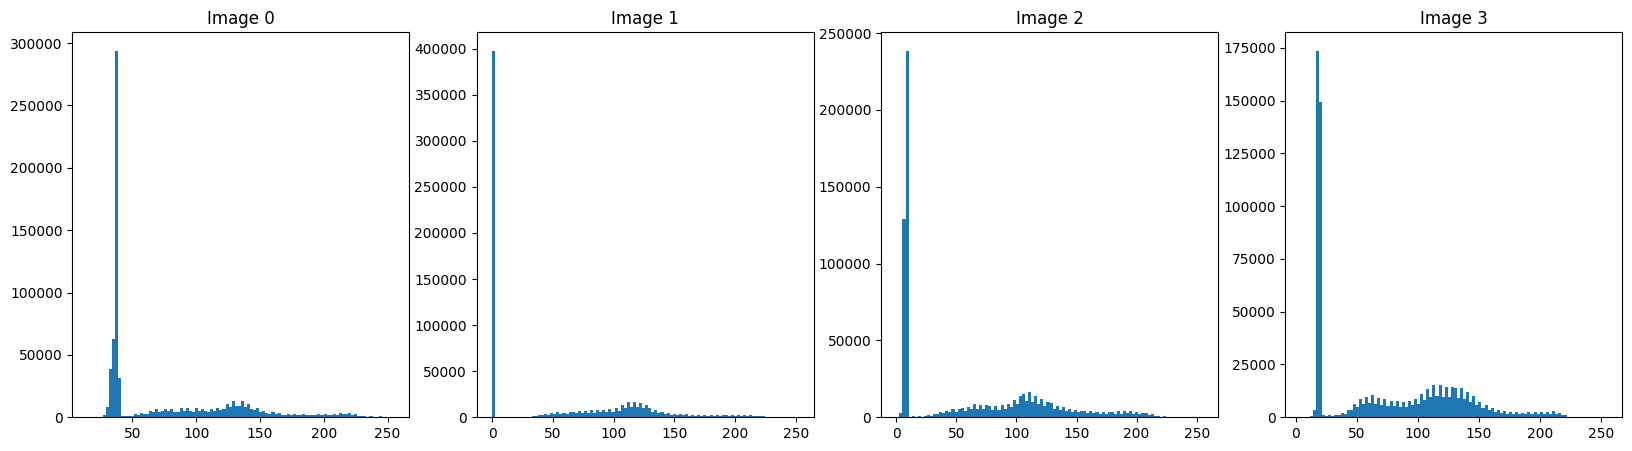

In [10]:
# show histogram of all images in imgs
imgs_2 = imgs
fig, axs = plt.subplots(1, len(imgs_2), figsize=(20, 5))
for i, img in enumerate(imgs_2):
    axs[i].hist(img.flatten(), bins=100)
    axs[i].set_title(f"Image {i}")

In [12]:
# # sed most predominant section of the histogram to zero
# im = imgs[0]
# im[im < 0.1] = 0